In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression

from statsmodels.stats.outliers_influence import variance_inflation_factor


In [23]:
df = pd.read_csv('training.csv')
df

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.000,0,0.0,16.3,31.6,16.0,low_bike_demand
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.000,0,0.0,23.9,85.7,16.0,low_bike_demand
2,21,3,8,0,1,1,26.9,21.8,73.39,0.000,0,0.0,0.0,81.1,16.0,low_bike_demand
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.000,0,0.0,19.2,0.0,16.0,low_bike_demand
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.000,0,0.0,10.5,44.6,16.0,low_bike_demand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,3,5,6,0,0,1,21.5,19.4,87.68,0.000,0,0.0,10.6,24.4,16.0,low_bike_demand
1596,14,0,6,0,1,1,23.2,20.1,82.43,2.217,0,0.0,9.8,92.1,10.4,low_bike_demand
1597,13,0,3,0,1,1,13.9,-2.2,32.93,0.000,0,2.0,18.2,79.3,16.0,low_bike_demand
1598,14,5,3,0,0,1,11.7,-9.3,22.09,0.000,0,0.0,5.8,24.4,16.0,high_bike_demand


In [24]:
# 1. Handle Missing Values
missing_values = df.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
hour_of_day       0
day_of_week       0
month             0
holiday           0
weekday           0
summertime        0
temp              0
dew               0
humidity          0
precip            0
snow              0
snowdepth         0
windspeed         0
cloudcover        0
visibility        0
increase_stock    0
dtype: int64


In [25]:
# 2. Handle Target Variable Encoding
df['increase_stock'] = df['increase_stock'].map({'low_bike_demand': 0, 'high_bike_demand': 1})

In [26]:
# 3. Handling Outliers using Isolation Forest (for highly skewed variables)
features = ['precip', 'snowdepth', 'visibility']
X = df[features]

iso_forest = IsolationForest(contamination=0.05)  # Set the contamination based on data
outliers = iso_forest.fit_predict(X)

df['outlier'] = np.where(outliers == -1, 1, 0)
df = df[df['outlier'] == 0]

In [27]:
# 4. Handle Multicollinearity using VIF
features_for_vif = df.select_dtypes(include=[np.number]).drop(columns=['increase_stock', 'outlier'])

vif_data = pd.DataFrame()
vif_data['Feature'] = features_for_vif.columns
vif_data['VIF'] = [variance_inflation_factor(features_for_vif.values, i) for i in range(len(features_for_vif.columns))]

high_vif_features = vif_data[vif_data['VIF'] > 10]
print("Features with High VIF (>10):")
print(high_vif_features)

Features with High VIF (>10):
       Feature         VIF
6         temp  101.136285
7          dew   51.327790
8     humidity   77.158628
14  visibility  123.966285


/Users/abhinavramalingam/Documents/Uppsala/SML/.conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [28]:
# 5. Split the dataset into training, testing, and validation sets using np.random.seed and random.choice
np.random.seed(32)  
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2
indices = np.random.permutation(len(df))  

train_size = int(len(df) * train_ratio)
val_size = int(len(df) * val_ratio)
test_size = len(df) - train_size - val_size  

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

X = df.drop(columns=['increase_stock', 'outlier'])  
y = df['increase_stock']  

X_train, X_val, X_test = X.iloc[train_indices], X.iloc[val_indices], X.iloc[test_indices]
y_train, y_val, y_test = y.iloc[train_indices], y.iloc[val_indices], y.iloc[test_indices]


In [29]:
# 6. Standardize the Data (Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [30]:
# 7. Apply KNN Classifier
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters from GridSearchCV:
{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}



Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       245
           1       0.73      0.37      0.49        59

    accuracy                           0.85       304
   macro avg       0.80      0.67      0.70       304
weighted avg       0.84      0.85      0.83       304



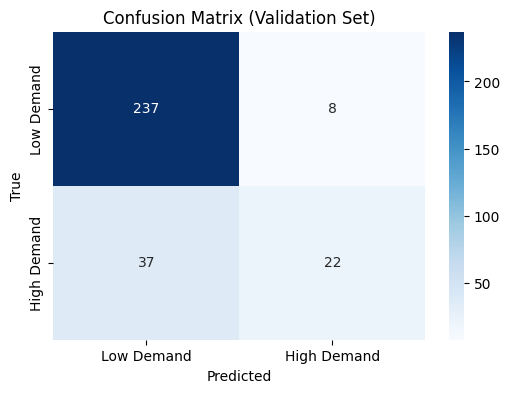


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       241
           1       0.56      0.32      0.40        63

    accuracy                           0.81       304
   macro avg       0.70      0.63      0.64       304
weighted avg       0.78      0.81      0.78       304



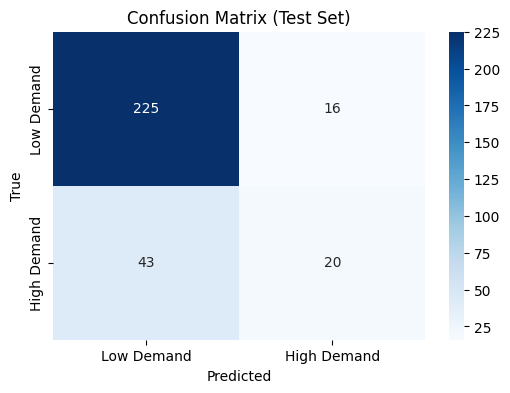

In [31]:
# 8. Evaluate the Model
best_knn = grid_search.best_estimator_

y_val_pred = best_knn.predict(X_val_scaled)
y_test_pred = best_knn.predict(X_test_scaled)

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Demand', 'High Demand'], yticklabels=['Low Demand', 'High Demand'])
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Demand', 'High Demand'], yticklabels=['Low Demand', 'High Demand'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()